In [1]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.api import tsa
from sklearn.metrics import mean_absolute_error, mean_squared_error

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_54431/3276810634.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv('../data/CDC/truth-Incident Hospitalizations.csv',index_col='date')
df_copy = df.copy()
df.index = pd.to_datetime(df.index)
df = df[df.index > '2020-10-10'] # Cut down the data before 2020-10-10
df.head()
df_state = df[df['location_name'] == 'Pennsylvania']
df_state_train = df_state.iloc[:-2, :]['value'] # Train set  
df_state_test = df_state.iloc[-2:, :]['value'] # Test set for validation
print(df_state_train.shape, df_state_test.shape)

(119,) (2,)


In [3]:
# cali_to_csv = pd.read_csv('/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv')
# cali_to_csv = cali_to_csv[cali_to_csv['location']=='06']
# cali_to_csv = cali_to_csv[:-2]
# cali_to_csv.to_csv('/Users/xiangyikong/Desktop/Flu_preprocess/cali_to_csv.csv', index=False)

In [4]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data 
seasonal_first_differencing = df_state_train.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -5.1031
p-value for Seasonal First Differencing: 0.0000


Text(0, 0.5, 'Autocorrelation')

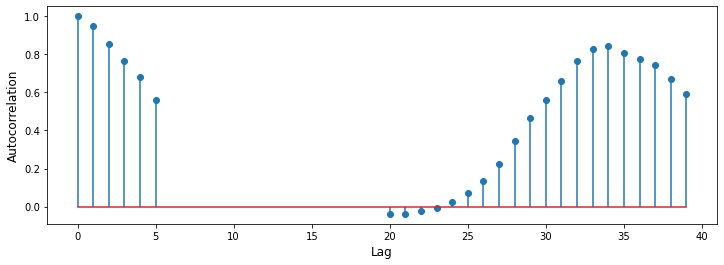

In [5]:
lags = [0,1,2,3,4,5,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39] 
autocorrs = [df_state_train.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

#### 8.5 month at lag of 34

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

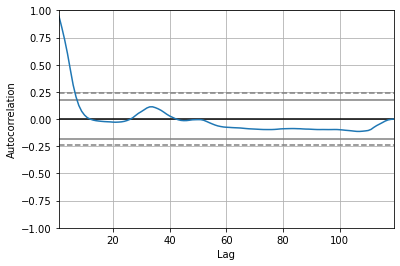

In [6]:
pd.plotting.autocorrelation_plot(df_state_train)

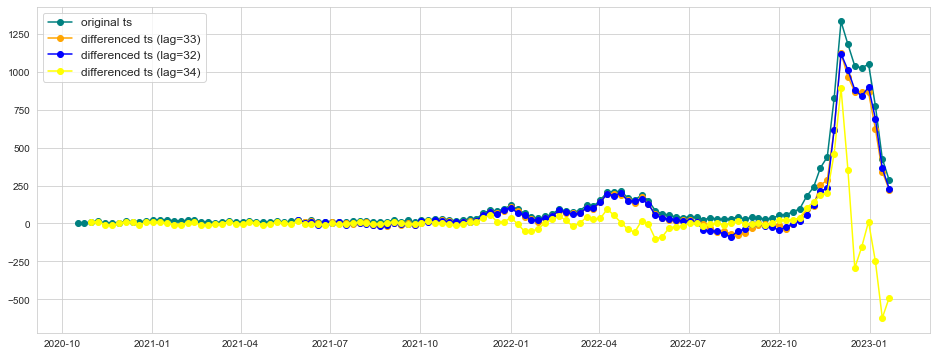

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(df_state_train, '-o', color='teal', label="original ts")
plt.plot(df_state_train.diff(33), '-o', color='orange', label="differenced ts (lag=33)")
plt.plot(df_state_train.diff(32), '-o', color='blue', label="differenced ts (lag=32)")
plt.plot(df_state_train.diff(2), '-o', color='yellow', label="differenced ts (lag=34)")
plt.legend(fontsize=12)

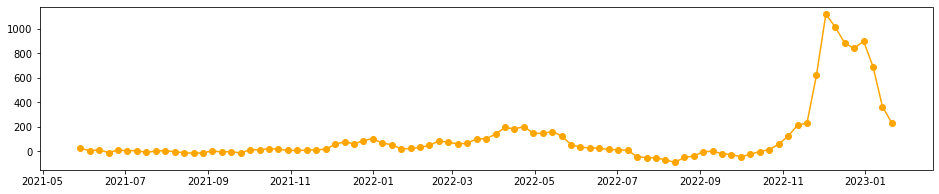

In [8]:
price_diff = df_state_train.diff(32).dropna() 

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')
time_series = price_diff 

#### AR

In [9]:
time_series.size

87

In [10]:
ar = tsa.AR(time_series)
optlag = ar.select_order(40, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag))

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

Best optimal lag for ar model: 5


/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


MAE = 35.557
MAE2 = 52.616


/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


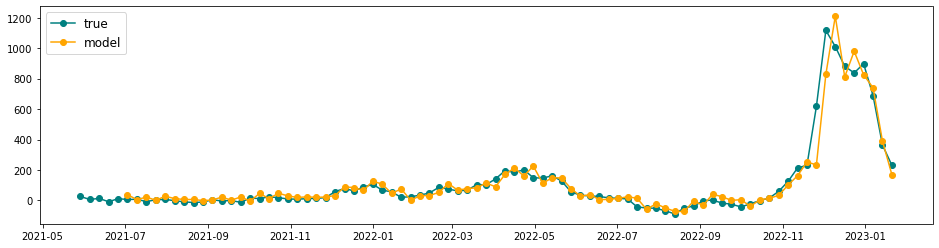

In [11]:
lag = optlag 
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-4:], ar_prediction[-4:]))) #error only for the last month

In [12]:
time_series

date
2021-05-29     26.0
2021-06-05      6.0
2021-06-12     13.0
2021-06-19     -9.0
2021-06-26     11.0
              ...  
2022-12-24    838.0
2022-12-31    898.0
2023-01-07    689.0
2023-01-14    364.0
2023-01-21    230.0
Name: value, Length: 87, dtype: float64

In [43]:
time_series = abs(time_series)

#### ARMA

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58417D+00    |proj g|=  1.53533D-02

At iterate    5    f=  5.58309D+00    |proj g|=  1.97575D-03

At iterate   10    f=  5.58306D+00    |proj g|=  3.43725D-05

At iterate   15    f=  5.58306D+00    |proj g|=  4.88054D-04

At iterate   20    f=  5.58303D+00    |proj g|=  5.70726D-03

At iterate   25    f=  5.58277D+00    |proj g|=  7.14806D-04

At iterate   30    f=  5.58277D+00    |proj g|=  1.23457D-05

At iterate   35    f=  5.58277D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

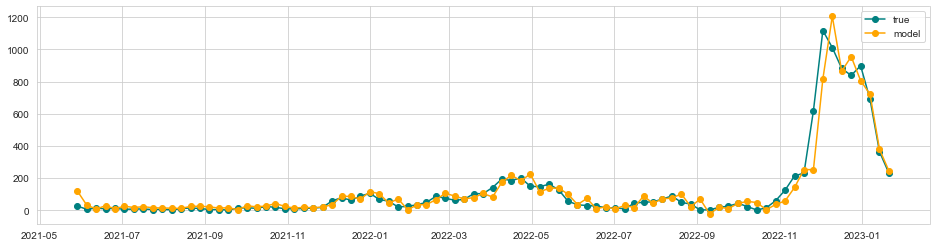

In [80]:
#arma = tsa.ARMA(time_series, order=(5, 4)) #7 p and 7 q for lag and moving average 
arma = tsa.ARMA(time_series, order=(1, 5)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=0
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-4:], arma_prediction[-4:]))) #error only for the last 90 days

In [15]:
time_series

date
2021-05-29     26.0
2021-06-05      6.0
2021-06-12     13.0
2021-06-19     -9.0
2021-06-26     11.0
              ...  
2022-12-24    838.0
2022-12-31    898.0
2023-01-07    689.0
2023-01-14    364.0
2023-01-21    230.0
Name: value, Length: 87, dtype: float64

In [81]:
#7 out of sample prediction with AR 
lag = 5
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+3)[-10:] 
ar_forecast

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

2022-12-17    804.308608
2022-12-24    978.714157
2022-12-31    816.175624
2023-01-07    740.062262
2023-01-14    385.568539
2023-01-21    169.117719
2023-01-28    144.137417
2023-02-04    -60.300596
2023-02-11   -283.552193
2023-02-18   -382.060881
Freq: W-SAT, dtype: float64

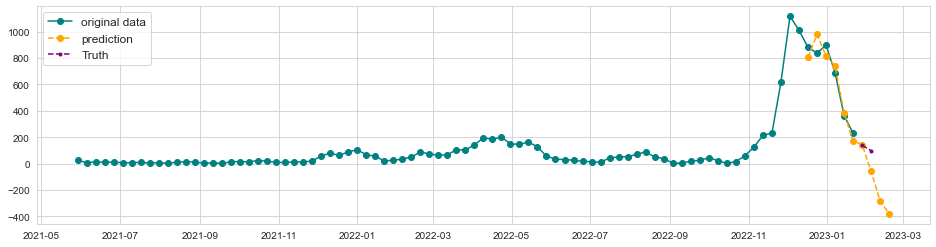

In [82]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)

In [83]:
df_state_test

date
2023-01-28    138
2023-02-04     98
Name: value, dtype: int64

In [84]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(1, 5)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+4)[-7:]
arma_forecast

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58417D+00    |proj g|=  1.53533D-02

At iterate    5    f=  5.58309D+00    |proj g|=  1.97575D-03

At iterate   10    f=  5.58306D+00    |proj g|=  3.43725D-05

At iterate   15    f=  5.58306D+00    |proj g|=  4.88054D-04

At iterate   20    f=  5.58303D+00    |proj g|=  5.70726D-03

At iterate   25    f=  5.58277D+00    |proj g|=  7.14806D-04

At iterate   30    f=  5.58277D+00    |proj g|=  1.23457D-05

At iterate   35    f=  5.58277D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

2023-01-14    379.408064
2023-01-21    244.269802
2023-01-28    167.689772
2023-02-04    166.019664
2023-02-11    120.641016
2023-02-18    104.164199
2023-02-25    109.082867
Freq: W-SAT, dtype: float64

In [85]:
arma.predict()

2021-05-29    119.963464
2021-06-05     31.947076
2021-06-12      7.548644
2021-06-19     27.889747
2021-06-26      9.135371
                 ...    
2022-12-24    955.024640
2022-12-31    806.179653
2023-01-07    720.207498
2023-01-14    379.408064
2023-01-21    244.269802
Freq: W-SAT, Length: 87, dtype: float64

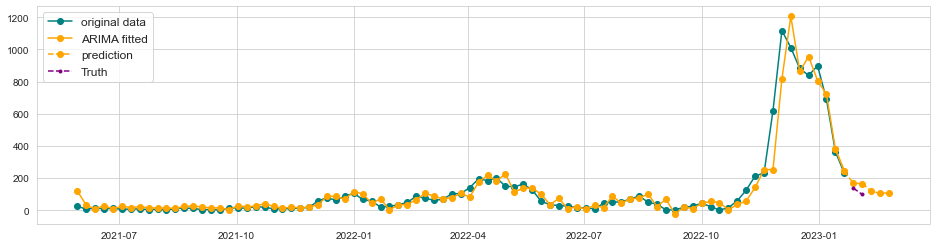

In [86]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma.predict(), '-o', label="ARIMA fitted", color='orange')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)

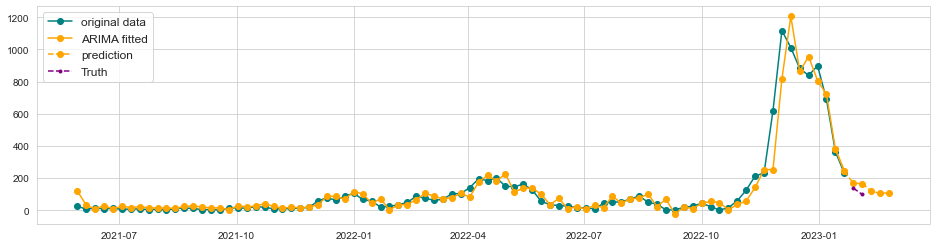

In [87]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma.predict(), '-o', label="ARIMA fitted", color='orange')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)

In [88]:
import seaborn as sns

In [89]:
arma.predict()

2021-05-29    119.963464
2021-06-05     31.947076
2021-06-12      7.548644
2021-06-19     27.889747
2021-06-26      9.135371
                 ...    
2022-12-24    955.024640
2022-12-31    806.179653
2023-01-07    720.207498
2023-01-14    379.408064
2023-01-21    244.269802
Freq: W-SAT, Length: 87, dtype: float64

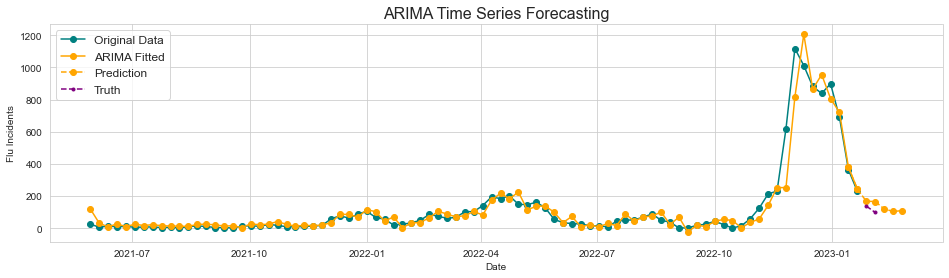

In [90]:

plt.figure(figsize=(16, 4))
sns.set_palette("colorblind")  # set color palette to be colorblind friendly
plt.plot(time_series, '-o', label="Original Data", color='teal')
plt.plot(arma.predict(), '-o', label="ARIMA Fitted", color='orange')
plt.plot(arma_forecast, '--o', label='Prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='purple')
plt.title("ARIMA Time Series Forecasting", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Flu Incidents")
plt.legend(fontsize=12)
plt.show()

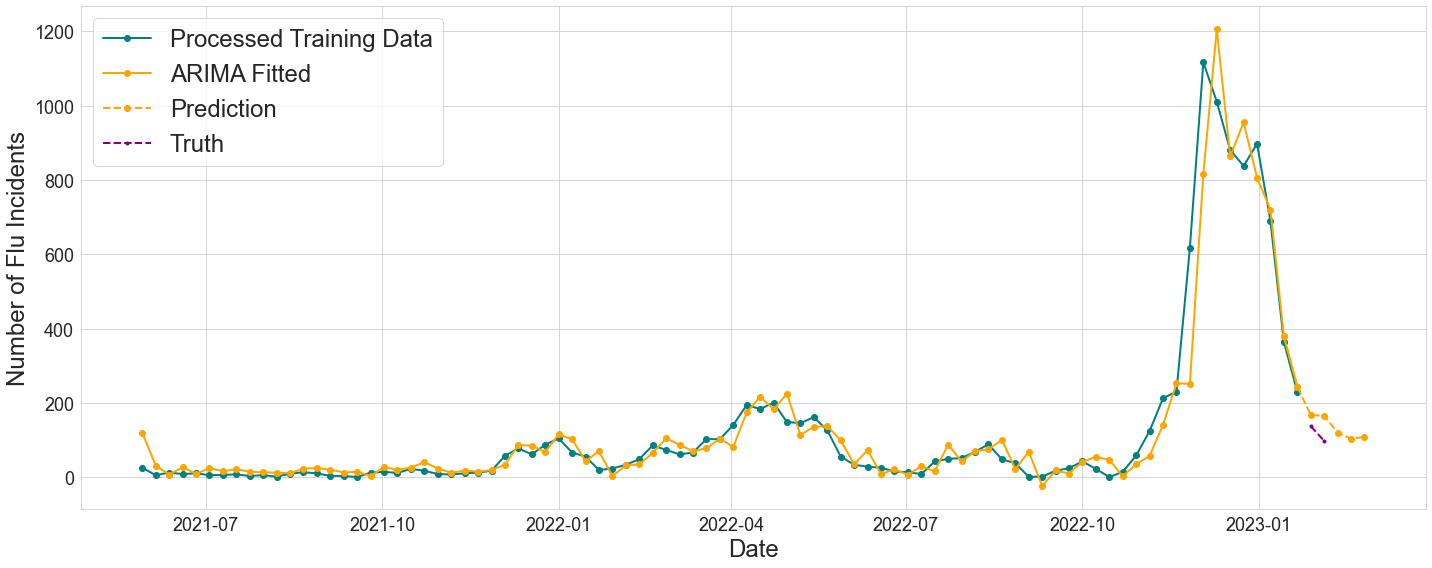

In [96]:
sns.set_style("whitegrid")  # set plot style to white grid
sns.set_palette("colorblind")  # set color palette to be colorblind friendly

fig, ax = plt.subplots(figsize=(20, 8))  # set figure size

# plot the data
ax.plot(time_series, '-o', label="Processed Training Data", color='teal', linewidth=2)
ax.plot(arma.predict(), '-o', label="ARIMA Fitted", color='orange', linewidth=2)
ax.plot(arma_forecast, '--o', label='Prediction', color='orange', linewidth=2)
ax.plot(df_state_test, '--.', label='Truth', color='purple', linewidth=2)

# set plot labels and legend
# ax.set_title("ARIMA Time Series Forecasting for Influenza Hospitalization", fontsize=32, fontweight='bold')
ax.set_xlabel("Date", fontsize=24)
ax.set_ylabel("Number of Flu Incidents", fontsize=24)
ax.tick_params(axis='both', labelsize=18)
ax.legend(fontsize=24)

# adjust plot layout and save the figure
plt.tight_layout()
plt.savefig("../references/arima_validation_plot1.png", dpi=300)

In [ ]:
df_state_test

date
2023-01-28    115
2023-02-04    119
Name: value, dtype: int64

In [ ]:
time_series

date
2021-06-12       4.0
2021-06-19      -2.0
2021-06-26     -14.0
2021-07-03     -26.0
2021-07-10     -35.0
               ...  
2022-12-24    1359.0
2022-12-31    1181.0
2023-01-07     546.0
2023-01-14     -32.0
2023-01-21    -207.0
Name: value, Length: 85, dtype: float64